In this notebook, we will look at one of the decarboxylative coupling datasets published by MacMillan and co-workers in Science 2022, 376 (6592), 532-539. In this dataset, a complex acid is coupled with many aryl bromides.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys
from scipy.stats import ks_2samp

# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14, # Legend titles
    "font.family": "Helvetica"   # Font
})


### Dataset processing

In [2]:
# load the full dataset from the publication
data = pd.read_csv("xec_raw_dset_full.csv",index_col=0, header=0)
data.head(3)

,Plate,Rxn_Plate_Row,Rxn_Plate_Col,Prod_Smiles,Rxn_Plate,Product_theoretical_umol,Target Mass,ArX_ID,ArX_Smiles,ArX_umol,...,Solution_Photocatalyst_solute,Solution_Ligand_ID,Solution_Ligand_Smiles,Solution_Ligand_umol,Solution_Ligand_equiv_rel_to_solute,Solution_Ligand_conc,Solution_Ligand_solute,CAD Yield,UV210_Prod AreaAbs,UV254_Prod AreaAbs
Reaction #,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)C4CC4,20hr_25C,0.1,314.13,MFCD00920757,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)Br,0.1,...,Catalyst,MFCD01863731,CC(C)(C)c1ccnc(c1)c2cc(ccn2)C(C)(C)C,0.015,1.5,Neat,Catalyst,1.5,0.0,0.0
2,1,1,2,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)C4(CC4...,20hr_25C,0.1,424.12,MFCD00920757,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)Br,0.1,...,Catalyst,MFCD01863731,CC(C)(C)c1ccnc(c1)c2cc(ccn2)C(C)(C)C,0.015,1.5,Neat,Catalyst,0.0,13409.8,1748.5
3,1,1,3,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)C4(CCC...,20hr_25C,0.1,438.13,MFCD00920757,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)Br,0.1,...,Catalyst,MFCD01863731,CC(C)(C)c1ccnc(c1)c2cc(ccn2)C(C)(C)C,0.015,1.5,Neat,Catalyst,6.0,147554.5,23453.8


The experimental data is divided into reaction carried out in the presence and absence of phthalimide as a reaction additive. We were interested in the reaction carried out with the additive.

In [3]:
# remove reactions without additive
data = data.loc[data["Additive_equiv"] != 0]
print("Remaining options for the additive equivalaents after filtering:", 
      list(data["Additive_equiv"].unique()))

Remaining options for the additive equivalaents after filtering: [1]


The aryl bromides were coupled with this acid:


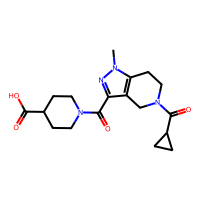

In [4]:
# show the acid
complex_acid = "Cn1c2c(c(n1)C(=O)N3CCC(CC3)C(=O)O)CN(CC2)C(=O)C4CC4"
print("The aryl bromides were coupled with this acid:")
Draw.MolToImage(Chem.MolFromSmiles(complex_acid),size=(200,200))

In [5]:
# filter for runs containing the complex acid (which is not present in the runs with the complex bromides)
data = data.loc[data["Acid_Smiles"] == complex_acid]
# The remaining reactions should be 384 reactions
print(f"There are {len(data)} reactions that were carried out with this acid.")

There are 384 reactions that were carried out with this acid.


In [6]:
# limit to columns that are required here
keep_col = ["Prod_Smiles","ArX_Smiles","Acid_Smiles","CAD Yield"]
# Ensure that the smiles are canonical
for col in ["Prod_Smiles","ArX_Smiles","Acid_Smiles"]:
    data[col] = [Chem.MolToSmiles(Chem.MolFromSmiles(smiles),canonical=True) for 
                 smiles in data[col].to_list()]
data = data[keep_col]
data.to_csv("xec_raw_dset_bromide_scope.csv")
data.head(3)

,Prod_Smiles,ArX_Smiles,Acid_Smiles,CAD Yield
Reaction #,,,,
2689,C[C@@H](NC(=O)OC(C)(C)C)c1ccc(C2CCN(C(=O)c3nn(...,C[C@@H](NC(=O)OC(C)(C)C)c1ccc(Br)cc1,Cn1nc(C(=O)N2CCC(C(=O)O)CC2)c2c1CCN(C(=O)C1CC1)C2,27.8
2690,CCOC(=O)c1nnc(C2CCN(C(=O)c3nn(C)c4c3CN(C(=O)C3...,CCOC(=O)c1nnc(Br)[nH]1,Cn1nc(C(=O)N2CCC(C(=O)O)CC2)c2c1CCN(C(=O)C1CC1)C2,5.8
2691,Cn1nc(C(=O)N2CCC(c3n[nH]c4c3CCOC4)CC2)c2c1CCN(...,Ic1n[nH]c2c1CCOC2,Cn1nc(C(=O)N2CCC(C(=O)O)CC2)c2c1CCN(C(=O)C1CC1)C2,0.8


In [7]:
# Confirm that all coupling partners are unique.
bromide_smiles = data["ArX_Smiles"].unique()
print(f"The {len(data)} reactions use {len(bromide_smiles)} unique aryl bromide coupling partners.")

The 384 reactions use 384 unique aryl bromide coupling partners.


Structures of the coupling partners:


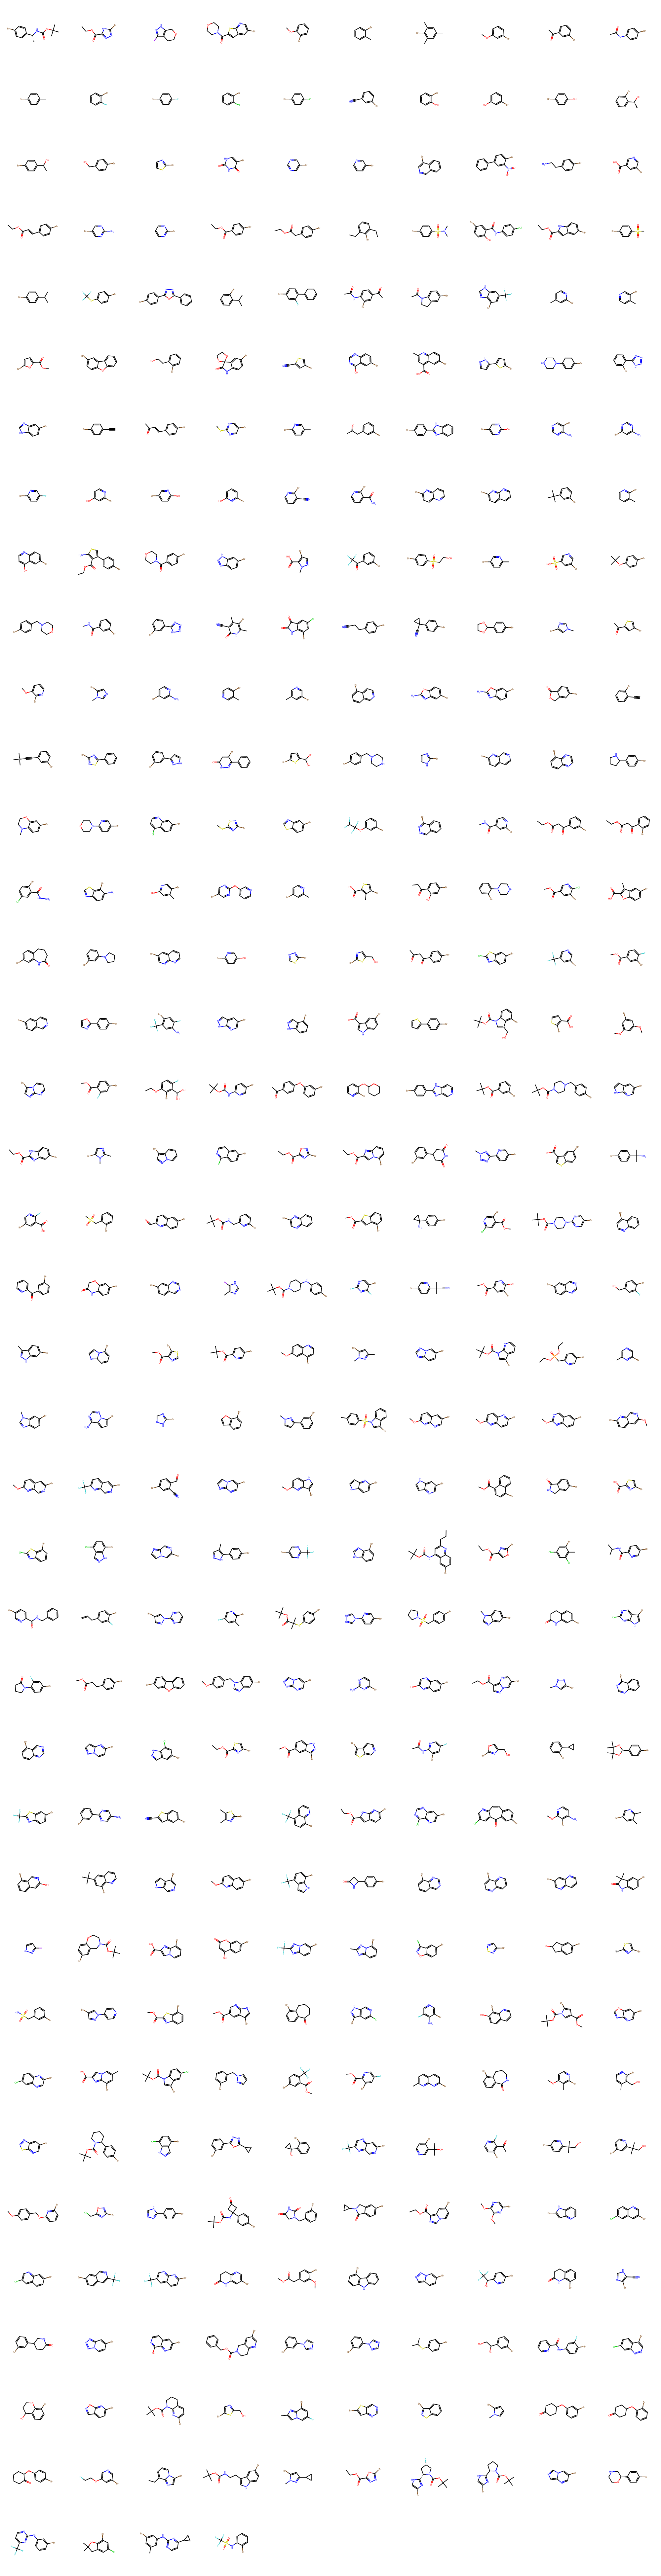

In [8]:
print("Structures of the coupling partners:")
Draw.MolsToGridImage([Chem.MolFromSmiles(bromide) for bromide in bromide_smiles],molsPerRow= 10,maxMols=10000,subImgSize=(200,200))

The dataset actually contains 3 aryl iodide coupling partners while the rest of the substrates are aryl bromides.

Structures of the aryl iodies in the dataset:


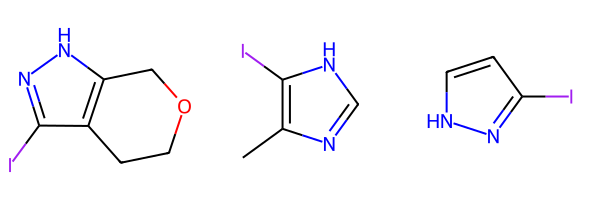

In [9]:
print("Structures of the aryl iodies in the dataset:")
iodide_smiles = [can for can in bromide_smiles if "I" in can]
Draw.MolsToGridImage([Chem.MolFromSmiles(can) for can in iodide_smiles],subImgSize=(200,200))

Remove these aryl iodides

In [10]:
bromide_smiles = [can for can in bromide_smiles if can not in iodide_smiles]

# limit the dataset to these canonical smiles
data = data.loc[data["ArX_Smiles"].isin(bromide_smiles)]
print("Remaining substrates after removing iodides:", len(data['ArX_Smiles']))

pd.DataFrame(bromide_smiles).to_csv("./Datasets/0_Descriptor_Calculation/xec_smiles_bromide_scope.csv",
                                    index = False, header = False)

Remaining substrates after removing iodides: 381


### Dataset analysis

Get some insights in the yield distribution

Number of samples: 381
Ratio of samples below 10% yield: 54.3%
Ratio of samples below 1% yield: 37.0%
Average yield: 16.9%
Highest yield in the dataset: 85.9%


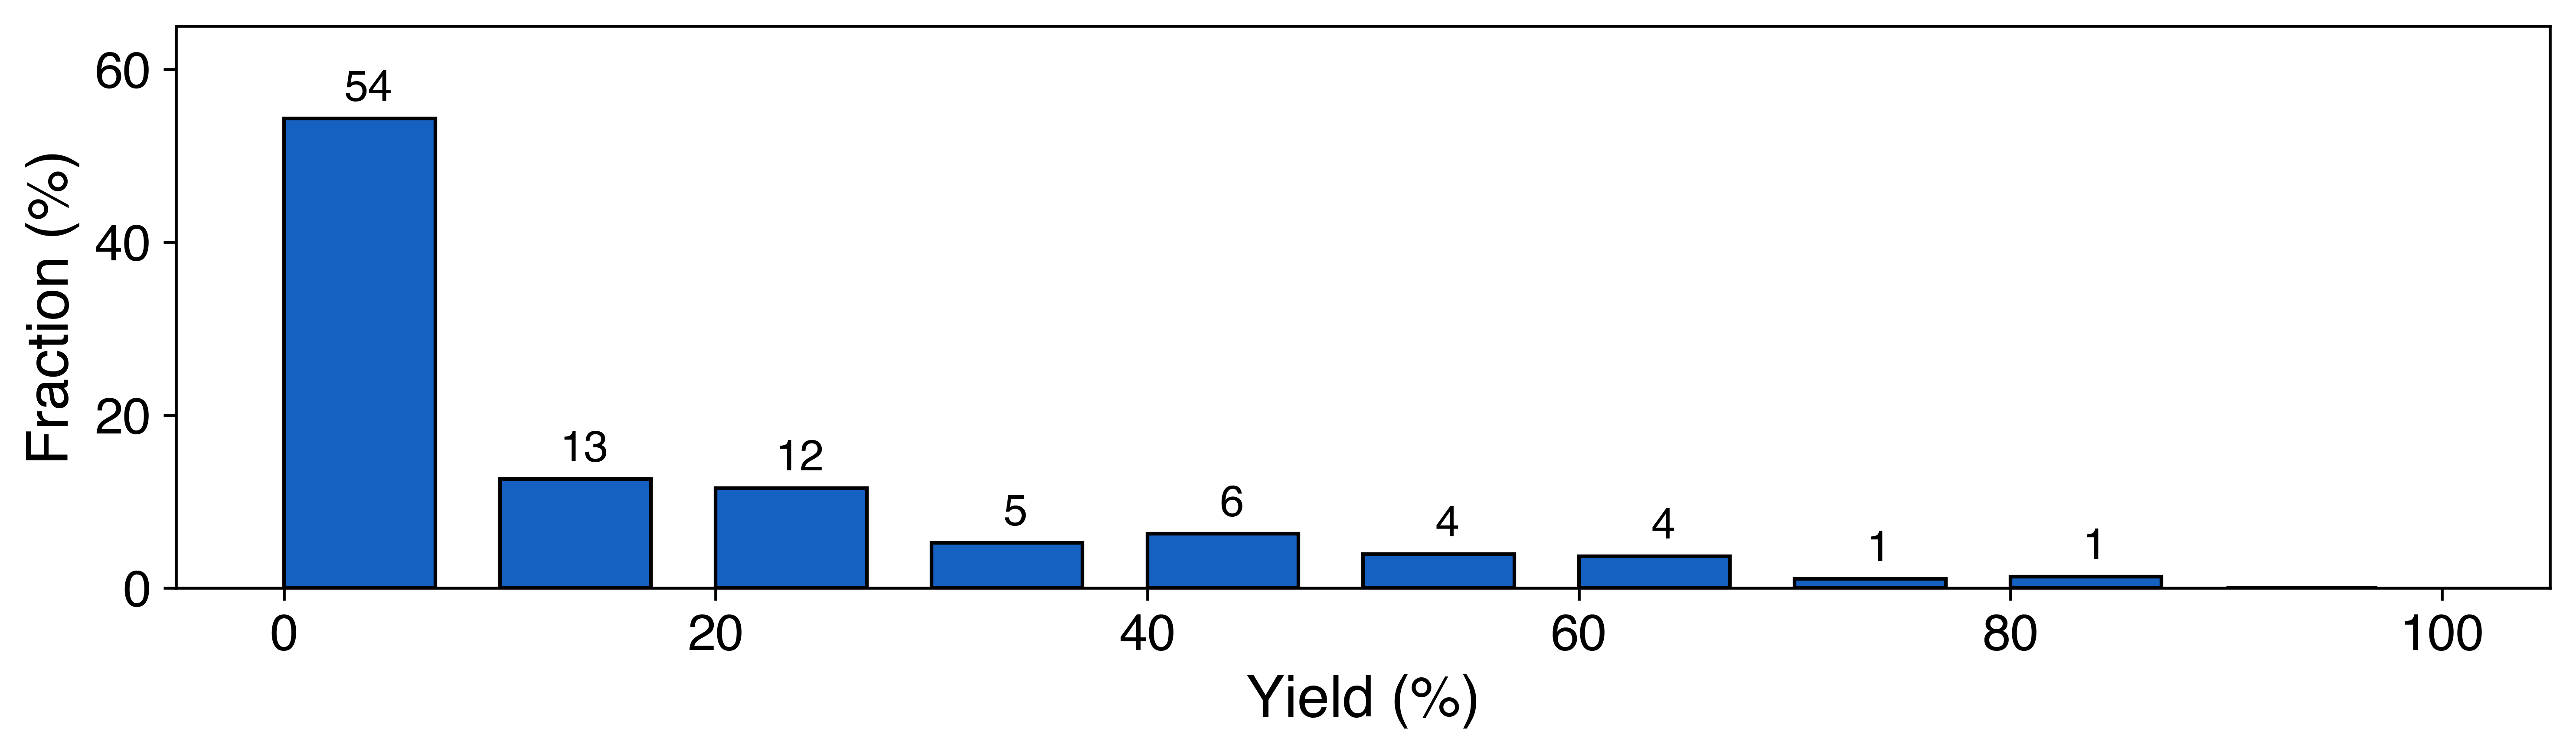

In [11]:
print(f"Number of samples: {len(data)}")

for cutoff_yield in [10, 1]:
    print(f"Ratio of samples below {cutoff_yield}% yield:"\
          f" {round(len(data.loc[data['CAD Yield'] < cutoff_yield])/len(data)*100, 1)}%")

print(f"Average yield: {round(data['CAD Yield'].mean(), 1)}%")
print(f"Highest yield in the dataset: {data['CAD Yield'].max()}%")

plt.figure(figsize=(10, 3), dpi=600)
counts, bins, patches = plt.hist(
    data["CAD Yield"],
    bins=10,
    range=(0, 100),
    weights=np.ones(len(data)) / len(data) * 100,  # normalize to percent
    color=all_colors[1],
    width = 7,
    edgecolor='k', alpha=1
)
for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]-2.2):
    if count > 0:  # only label non-empty bins
        plt.text(
            (bin_left + bin_right) / 2,  # x position (center of bar)
            count + 1,
            f"{count:.0f}",
            ha='center', va='bottom', fontsize=12
        )

# Axis labels and limits
plt.xlabel("Yield (%)")
plt.ylabel("Fraction (%)")
plt.ylim(0, 65)
plt.tight_layout()
plt.show()



The performance of the dataset is very low as more than half the samples give less than 10% yield and 37% of samples do not give any product at all.

In [12]:
def normalize(data):
    min_val = data.min()
    max_val = data.max()
    return data.apply(lambda x: (x- min_val) / (max_val - min_val))

print("Kolmogorov-Smirnov analysis for the unpruned decarboxylation bromide dataset compared to the low-performing ArI dataset ArI-DS-low:\n")
df_ari = pd.read_csv(f"./../../dataset_ArI/0_Data/Datasets/Datasets_Hyperpar_Opt/data-low.csv",index_col=0)

statistic, p_value = ks_2samp(normalize(df_ari["rate"]), normalize(data["CAD Yield"]))

print("KS statistic:", statistic)
print("p value:", p_value)
print("")
print("Note: The data was normalized to only compare the distribution shape.")


Kolmogorov-Smirnov analysis for the unpruned decarboxylation bromide dataset compared to the low-performing ArI dataset ArI-DS-low:

KS statistic: 0.34408989245994054
p value: 9.517144372630227e-30

Note: The data was normalized to only compare the distribution shape.


### Dataset pruning

Due to the low performance, we were interested to see if we could improve the performance by remove substrates with poorly tolerated functional groups.

Specifically, we analyzed of many examples of compounds containing a specified functional group provide "positive" (i. e. ≥10% yield) and "negative" (>10% yield) results.

In [13]:
# set up dfs for the analysis
data_neg = data.loc[data["CAD Yield"] < 10].copy()
data_neg.set_index("ArX_Smiles",inplace=True)
data_neg = data_neg.drop(columns=["Prod_Smiles","Acid_Smiles"])
data_pos = data.loc[data["CAD Yield"] >= 10].copy()
data_pos.set_index("ArX_Smiles",inplace=True)
data_pos = data_pos.drop(columns=["Prod_Smiles","Acid_Smiles"])

In [14]:
def functionality_lookup(smarts_functionality):
    """Returns how often the queried functionality occurs in the datasets."""

    pattern_functionality = Chem.MolFromSmarts(smarts_functionality)

    counter_neg = 0
    matching_smiles = []
    for smiles in data_neg.index:
        mol = Chem.MolFromSmiles(smiles)
        match_functionality = mol.HasSubstructMatch(pattern_functionality)
        if match_functionality:
            counter_neg +=1
            matching_smiles.append(smiles)

    counter_pos = 0
    for smiles in data_pos.index:
        mol = Chem.MolFromSmiles(smiles)
        match_functionality = mol.HasSubstructMatch(pattern_functionality)
        if match_functionality:
            counter_pos +=1
            matching_smiles.append(smiles)

    return matching_smiles, counter_pos, counter_neg

Probe different functional groups and select poorly performing ones for pruning

In [15]:
smiles_collection = {}
df_fg = pd.DataFrame(columns=["Smarts","Positive results","Negative results"])

def fg_analysis(smarts,name):
    """Set up a df containing the fg_analysis (df_fg)."""
    matching_smiles, counter_pos, counter_neg = functionality_lookup(smarts_functionality=smarts)
    smiles_collection[name] = matching_smiles
    df_fg.loc[name] = [smarts, counter_pos, counter_neg]

In [16]:
fg_analysis("c1ncccc1", "pyridine")
fg_analysis("c1cccnc1Br", "2-bromopyridines")
fg_analysis("c1nccc1", "pyrrole")
fg_analysis("c1nncc1", "pyrazole")
fg_analysis("c1ncnc1", "imidazole")
fg_analysis("c1ncoc1", "oxazole")
fg_analysis("c1ncsc1", "thiazole")
fg_analysis("no", "N-O heteroaromatic")
fg_analysis("ns", "N-S heteroaromatic")
fg_analysis("c[OH1]", "phenol")
fg_analysis("[C,c]C(=O)[OH1]", "acid")
fg_analysis("[C,c]C(=O)O[C,c]", "ester")
fg_analysis("[C,c]C(=O)N", "amide")
fg_analysis("[CH1](=O)", "aldehyde")
fg_analysis("[C,c]C(=O)[C,c]", "ketone")
fg_analysis("N(=O)O", "nitro")
fg_analysis("cF", "ArF")
fg_analysis("cCl","ArCl")
fg_analysis("c(C)cBr","ortho-subst. arene")
fg_analysis("n(C)cBr","ortho-subst arene part 2")
fg_analysis("C#N","nitrile")
fg_analysis("[NH0]","tert. amine")
fg_analysis("[NH1]", "sec. amine")
fg_analysis("[NH2]", "prim. amine")
fg_analysis("[nH1]", "N-H aromatic")
df_fg

,Smarts,Positive results,Negative results
pyridine,c1ncccc1,60,67
2-bromopyridines,c1cccnc1Br,22,12
pyrrole,c1nccc1,6,15
pyrazole,c1nncc1,11,10
imidazole,c1ncnc1,16,12
oxazole,c1ncoc1,3,3
thiazole,c1ncsc1,2,12
N-O heteroaromatic,no,0,4
N-S heteroaromatic,ns,0,5
phenol,c[OH1],8,11


Based on the data collected above, we selected to remove compounds containing the following FG from the dataset: thiazoles, N-O and N-S heteroaromatics, acids, esters, aldehyds, nitros, aromatic chlorides, ortho-substituted aromatics (benzene and pyridine - since this is what would be done in an experimental campaign).

In [17]:
pruned_bromides = [smiles for smiles in bromide_smiles]
removed_bromides = []
counter = 0
for fg in ["thiazole", "N-O heteroaromatic", "N-S heteroaromatic",
           "acid", "ester", "aldehyde", "nitro", "ArCl",
           "ortho-subst. arene", "ortho-subst arene part 2"]:
    for smiles in smiles_collection[fg]:
        # might already have been removed because it contains another difficult FG --> check
        if smiles in pruned_bromides:
            pruned_bromides.remove(smiles)
            removed_bromides.append(smiles)
            counter += 1
    print(f"Removed {fg}s.")
print(f"Removed a total of {counter} compounds from the dataset.")

Removed thiazoles.
Removed N-O heteroaromatics.
Removed N-S heteroaromatics.
Removed acids.
Removed esters.
Removed aldehydes.
Removed nitros.
Removed ArCls.
Removed ortho-subst. arenes.
Removed ortho-subst arene part 2s.
Removed a total of 123 compounds from the dataset.


Dataset after filtering by functional group:
Number of samples: 258
Ratio of samples below 10% yield: 41.9%
Ratio of samples below 1% yield: 28.7%
Average yield: 21.5%


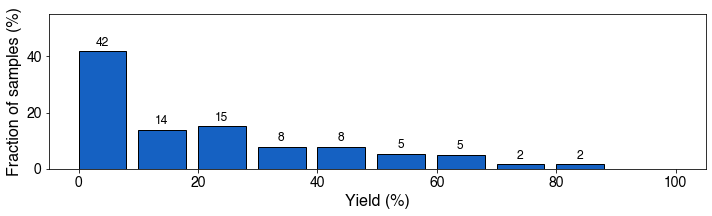

In [18]:
print("Dataset after filtering by functional group:")
data_pruned = data.loc[data["ArX_Smiles"].isin(pruned_bromides)].copy()
print(f"Number of samples: {len(data_pruned)}")
for cutoff_yield in [10, 1]:
    print(f"Ratio of samples below {cutoff_yield}% yield:"\
          f" {round(len(data_pruned.loc[data_pruned['CAD Yield'] < cutoff_yield])/len(data_pruned)*100,1)}%")

print(f"Average yield: {round(data_pruned['CAD Yield'].mean(),1)}%")

plt.figure(figsize=(10, 3))
counts, bins, patches = plt.hist(data_pruned["CAD Yield"], bins=10, range=(0, 100), 
         weights=[100/len(data_pruned["CAD Yield"])]*len(data_pruned["CAD Yield"]),
         edgecolor="k", color=all_colors[1], width = 8)
plt.tick_params(axis='both', which='major')
for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]-2.2):
    if count > 0:  # only label non-empty bins
        plt.text(
            (bin_left + bin_right) / 2,  # x position (center of bar)
            count + 1,
            f"{count:.0f}",
            ha='center', va='bottom', fontsize=12
        )
plt.xlabel("Yield (%)")
plt.ylabel("Fraction of samples (%)")
plt.ylim(0,55)
plt.tight_layout()
plt.show()

In [19]:
def normalize(data):
    min_val = data.min()
    max_val = data.max()
    return data.apply(lambda x: (x- min_val) / (max_val - min_val))

print("Kolmogorov-Smirnov analysis for the pruned decarboxylation bromide dataset compared to the low-performing ArI dataset ArI-DS-low:\n")
df_ari = pd.read_csv(f"./../../dataset_ArI/0_Data/Datasets/Datasets_Hyperpar_Opt/data-low.csv",index_col=0)

statistic, p_value = ks_2samp(normalize(df_ari["rate"]), normalize(data_pruned["CAD Yield"]))

print("KS statistic:", statistic)
print("p value:", p_value)
print("")
print("Note: The data was normalized to only compare the distribution shape.")


Kolmogorov-Smirnov analysis for the pruned decarboxylation bromide dataset compared to the low-performing ArI dataset ArI-DS-low:

KS statistic: 0.2634904835158206
p value: 4.1683215404749645e-13

Note: The data was normalized to only compare the distribution shape.


In [20]:
# check also the performance of the removed samples
counter_zero = 0
counter_poor = 0
counter_good = 0
for idx in data.index:
    if data.loc[idx,"ArX_Smiles"] in removed_bromides:
        if data.loc[idx,"CAD Yield"] == 0:
            counter_zero += 1
        elif data.loc[idx,"CAD Yield"] <= 10:
            counter_poor += 1
        else:
            counter_good += 1

In [21]:
print("The removed substrates gave the following results:")
print("Substrates that gave no yield at all:", counter_zero)
print("Substrates that gave a yield between 0% and 10%:", counter_poor)
print("Substrates that gave more than 10% yield:", counter_good)

The removed substrates gave the following results:
Substrates that gave no yield at all: 56
Substrates that gave a yield between 0% and 10%: 43
Substrates that gave more than 10% yield: 24


Pruning these functional groups improves the dataset characteristics although they remain low.

Comparison of the two datasets (unpruned and pruned):

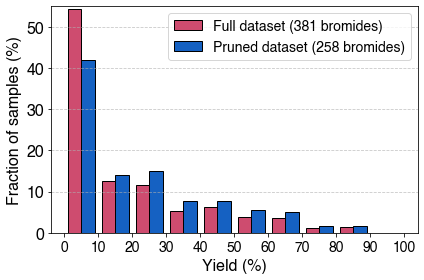

In [22]:
# Define bins
bins = np.linspace(0, 100, 11)  # 10 bins from 0–100
bin_centers = (bins[:-1] + bins[1:]) / 2

# Compute histograms
counts_pruned, _ = np.histogram(data_pruned["CAD Yield"], bins=bins)
counts_orig, _ = np.histogram(data["CAD Yield"], bins=bins)

# Normalize to percentages relative to each dataset
perc_pruned = counts_pruned / counts_pruned.sum() * 100
perc_orig = counts_orig / counts_orig.sum() * 100

# Plot side by side
width = (bins[1] - bins[0]) * 0.4  # narrower bars
plt.figure(figsize=(6,4))
plt.bar(bin_centers - width/2, perc_orig, width=width, color=all_colors[0], label="Full dataset (381 bromides)",edgecolor="k")
plt.bar(bin_centers + width/2, perc_pruned, width=width, color=all_colors[1], label="Pruned dataset (258 bromides)",edgecolor="k")
plt.xlabel("Yield (%)")
plt.ylabel("Fraction of samples (%)")
plt.xticks(np.arange(0, 110, 10))
plt.yticks(fontsize=16)
plt.ylim(0,55)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


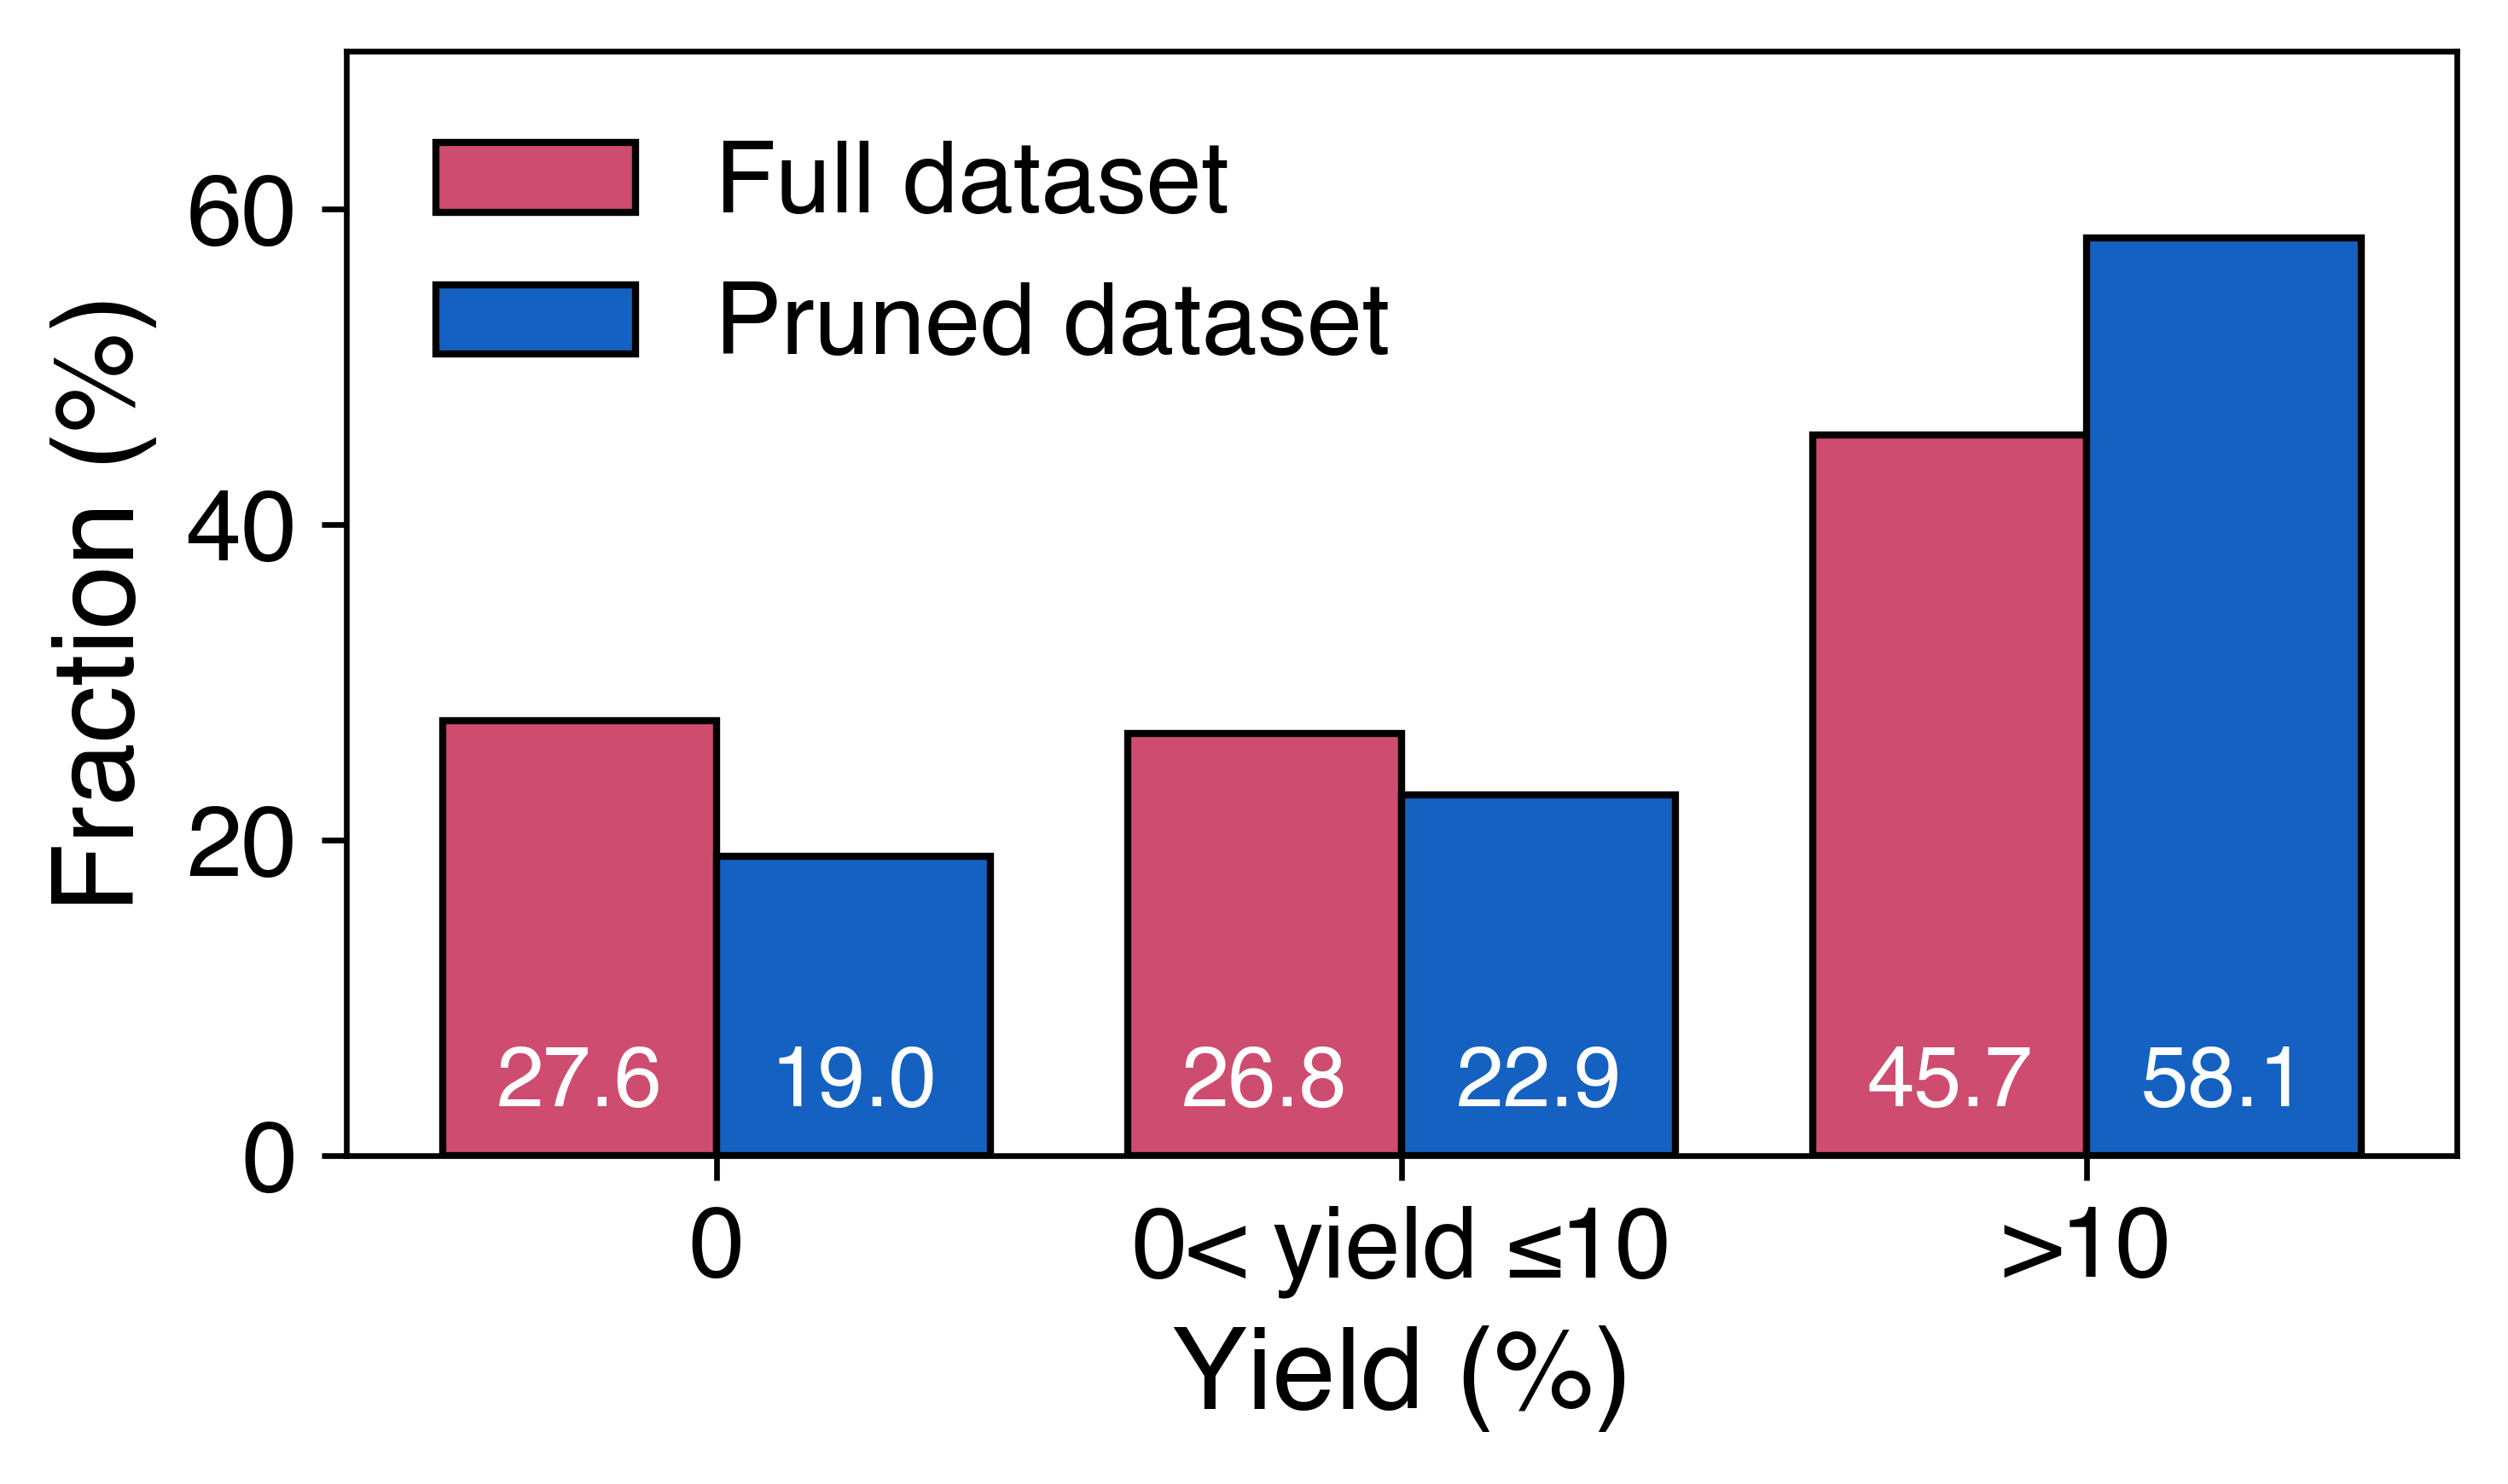

In [23]:
# make another plot that classifies the yields by performance categories

# Define bins and labels
bins = [-1000, 0, 10, 1000]
labels = ['0', '0< yield ≤10', '>10']

# Cut into bins
data_pruned['bin'] = pd.cut(data_pruned['CAD Yield'], bins=bins, labels=labels, right=True)
data['bin'] = pd.cut(data['CAD Yield'], bins=bins, labels=labels, right=True)

# Compute normalized percentages for each bin
counts_data = data['bin'].value_counts(normalize=True).sort_index() * 100
counts_pruned = data_pruned['bin'].value_counts(normalize=True).sort_index() * 100

# Ensure both series align by index (in case one is missing a category)
all_bins = sorted(set(counts_data.index) | set(counts_pruned.index))
counts_data = counts_data.reindex(all_bins, fill_value=0)
counts_pruned = counts_pruned.reindex(all_bins, fill_value=0)

# Set up positions for grouped bars
x = np.arange(len(all_bins))
width = 0.4  # width of the bars

plt.figure(figsize=(5, 3), dpi=600)
plt.bar(x - width/2, counts_data, width, label='Full dataset', color=all_colors[0], edgecolor='k')
plt.bar(x + width/2, counts_pruned, width, label='Pruned dataset', color=all_colors[1], edgecolor='k')
plt.xticks(x, all_bins)
plt.ylabel('Fraction (%)')
plt.ylim(0,70)
plt.xlabel('Yield (%)')
plt.legend(frameon=False)

# Add values
for i, v in enumerate(counts_data):
    plt.text(x[i] - width/2, 2, f'{v:.1f}', ha='center', va='bottom', fontsize=12, c ="white")
for i, v in enumerate(counts_pruned):
    plt.text(x[i] + width/2, 2, f'{v:.1f}', ha='center', va='bottom', fontsize=12,c="white")

plt.tight_layout()
plt.show()

In [24]:
data_pruned.to_csv("xec_raw_dset_bromide_scope_pruned.csv")